In [1]:
from IPython.display import display, Markdown
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', None)
df0 = pd.read_csv('results.csv')
df = pd.read_csv('results_clean.csv')
df.head(5)

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,consortium[berd],consortium[daphne4nfdi],consortium[dataplant],...,metadata[citationcff],metadata[zenodojson],metadata[other],ontologies,sourcecode[none],sourcecode[private],sourcecode[gitlab],sourcecode[github],sourcecode[unsure],sourcecode[other]
0,12,2025-03-03 11:47:58,3,en,1231948694,2025-03-03 11:17:44,2025-03-03 11:47:58,NaN,NaN,NaN,...,Y,Y,NaN,Whatever is used by established formats (ORCID...,NaN,NaN,NaN,Y,NaN,NaN
1,25,2025-03-04 09:17:06,3,en,1060284714,2025-03-04 09:13:55,2025-03-04 09:17:06,NaN,NaN,NaN,...,Y,NaN,NaN,"EDAM,bioschemas,RO-Crate",NaN,NaN,NaN,Y,NaN,NaN
2,28,2025-03-04 09:52:42,3,en,1823998022,2025-03-04 09:46:36,2025-03-04 09:52:42,NaN,NaN,NaN,...,NaN,NaN,looking at https://bioschemas.org/profiles/Com...,"EDAM, others may apply",NaN,Y,Y,Y,NaN,Approaches may differ depending on service
3,30,2025-03-05 10:15:04,3,en,1304676296,2025-03-05 10:12:18,2025-03-05 10:15:04,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN
4,33,2025-03-05 11:10:51,3,en,1615038268,2025-03-05 10:28:31,2025-03-05 11:10:51,Y,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,don't know


In [2]:
df0["startdate"] = pd.to_datetime(df0["startdate"]).dt.date
date_series = df0["startdate"].dropna()
mindate = date_series.min()
maxdate = date_series.max()
display("The "+str(len(df0))+" survey responses were submitted between "+mindate.strftime('%d %B %Y')+" and "+maxdate.strftime('%d %B %Y')+".")
df["startdate"] = pd.to_datetime(df["startdate"]).dt.date
date_series = df["startdate"].dropna()
mindate = date_series.min()
maxdate = date_series.max()
display("As we made most questions optional to increase participations, we had to manually remove empty and test entries, leaving "+str(len(df))+" survey responses submitted between "+mindate.strftime('%d %B %Y')+" and "+maxdate.strftime('%d %B %Y')+".")

'The 113 survey responses were submitted between 03 March 2025 and 24 March 2025.'

'As we made most questions optional to increase participations, we had to manually remove empty and test entries, leaving 34 survey responses submitted between 03 March 2025 and 19 March 2025.'

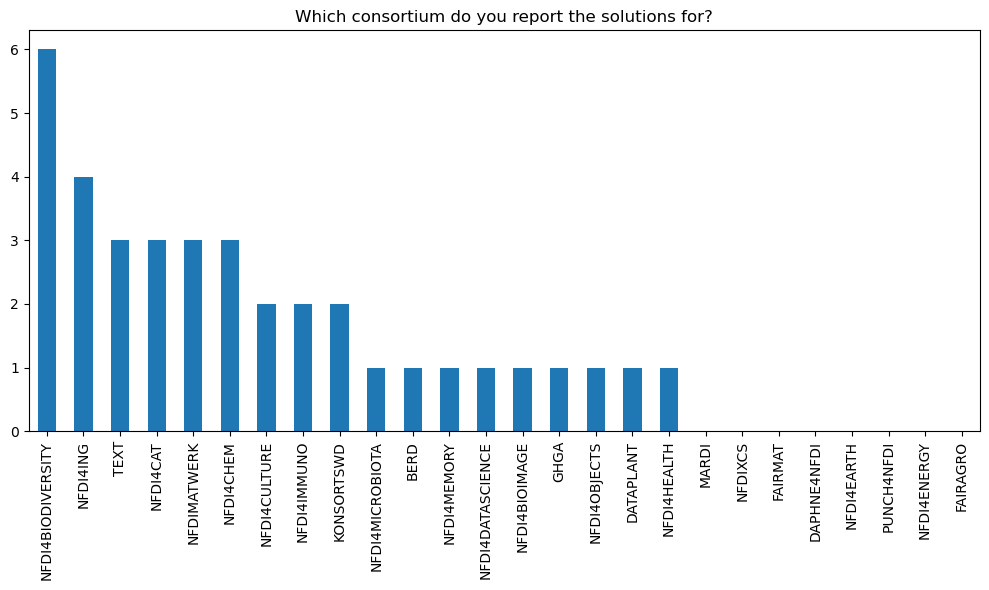

'Of the 26 consortia, 26 had at least one representative answer the survey.'

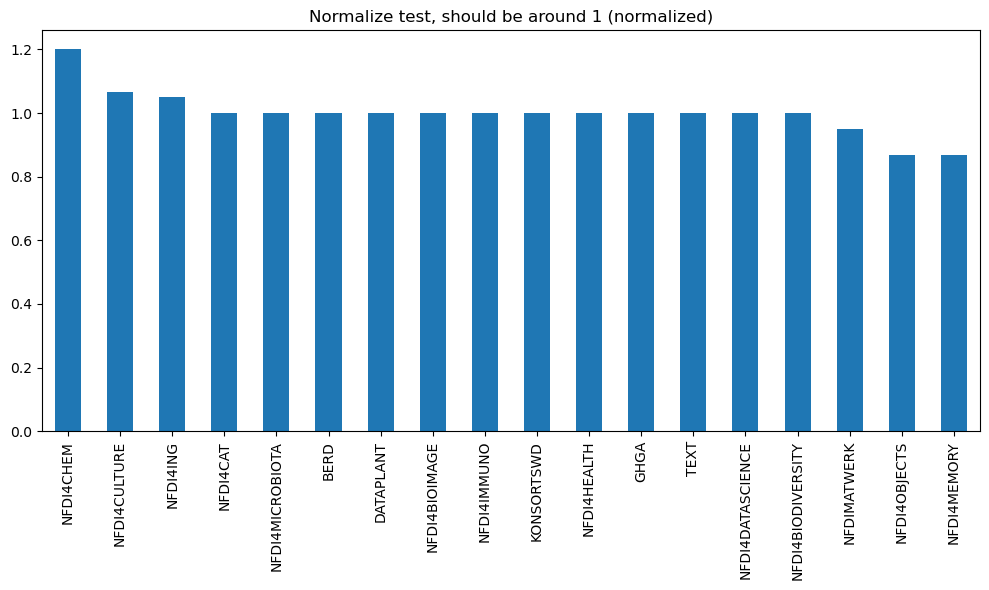

In [38]:
def col_count(prefix,title):
    # prevent aggregate column from being aggregated with itself
    cols = {col for col in df.columns if isinstance(col, str) and col.startswith(prefix) and not "other" in col and not "comment" in col and col!=prefix}
    counts = {}
    df[prefix] = [set() for _ in range(len(df))]
    aggregate = df[prefix]
    for col in cols:
            # string type columns are mistakenly recognized as objects 
            df[col] = df[col].fillna('').astype(str)
            #display(df[col])
            new_col_name = re.sub(prefix+r"\[(.*)\]", lambda m: m.group(1).upper(), col)
            counts[new_col_name] = int((df[col] == 'Y').sum())
            named = df[col].replace('Y', new_col_name).astype(str)
            for index, _value in named.items():
                name = named.at[index]
                if name:
                     if not isinstance(name,str): 
                        display("Warning: name is not a string value : "+str(name))
         
            if new_col_name == 'OTHER':
                continue
            for index, _value in aggregate.items():
                cons = named.at[index]
                if cons:
                    if not isinstance(cons,str): 
                            display("Warning: consortium is not a string value : "+str(cons))
                            continue
                    if "{" in cons:
                        display("invalid character in consortium: '"+cons+"'")
                    #display("before",aggregate.at[index],"adding "+cons)
                    aggregate.at[index].add(cons)
                    #display("result:",aggregate.at[index])
    df[prefix] = aggregate
 
    sorted_counts  = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    #display(sorted_counts)
    pd.Series(sorted_counts).plot(kind='bar', figsize=(10, 6), rot=90, title=title)
    yint = range(0, max(sorted_counts.values())+1) # automatic axis doesn't always show whole numbers
    plt.yticks(yint)
    plt.tight_layout()
    plt.show()
    return sorted_counts

cons_count = col_count("consortium","Which consortium do you report the solutions for?")
display(f"Of the {len(cons_count.keys())} consortia, {len(cons_count.keys())} had at least one representative answer the survey.")
#display(df["consortium"])

# if someone belongs to n consortia, count those only as 1/n for correct normalization of the other columns 
def cons_count_normalize():
    counts = {}
    for consortia in df["consortium"]:
        for consortium in consortia:
            if not consortium in counts:
                    counts[consortium] = 0
            counts[consortium] += len(consortia)
    return counts

cons_count_normalized = cons_count_normalize()
#display(cons_count_normalized)

# normalization still in progress
def col_count_normalize(prefix,title):
    #cols = {col for col in df.columns if isinstance(col, str) and col.startswith(prefix)}
    counts = {}
    # aggregated consortium values created by calling col_count("consortium",...) first
    cons = df["consortium"]
    #display(cons)
    
    normalized_counts = {}
    aggregated = df[prefix]
    #for col in cols:
            #new_col_name = re.sub(prefix+r"\[(.*)\]", lambda m: m.group(1).upper(), col)
            #counts = int((df[col] == 'Y').sum())
    for index, values in aggregated.items():
            # using the aggregated column where the values are a set
            # alternatively we could also use the non-aggregated columns
            for value in values:
                if not value in normalized_counts:
                    normalized_counts[value] = 0
                consortia = cons.at[index]
            # ignore answers which did not specify a consortium, alternatively one could also assign a constant value to them
                if len(consortia)>0:
                    #display(consortia)
                    weights = list(map(lambda c: 1/max(1,cons_count_normalized[c]),consortia))
                    # the results get a bit wierd if people are part of multiple consortia, I just tried different ways of aggregation and the average provided values most closely to 1.0
                    # feel free to propose a better way, or is there even a standard? We can't be the first ones with this problem.
                    weight = sum(weights)
                    normalized_counts[value] += weight
    sorted_counts  = dict(sorted(normalized_counts.items(), key=lambda item: item[1], reverse=True))
    pd.Series(sorted_counts).plot(kind='bar', figsize=(10, 6), rot=90, title=title+" (normalized)")
    plt.tight_layout()    
    plt.show()
    #return normalized_counts

# normalizing consoritium on itself does not produce helpful insights but we can verify that normalization works because the scores should all be 1 or close to it depending on how we treat special cases
# Python or Math experts, feel free to point out if I made errors somewhere or if you know a better formula for normalizations, but in the end I think it is not that cricial because we want to get a rough overview
col_count_normalize("consortium","Normalize test, should be around 1")

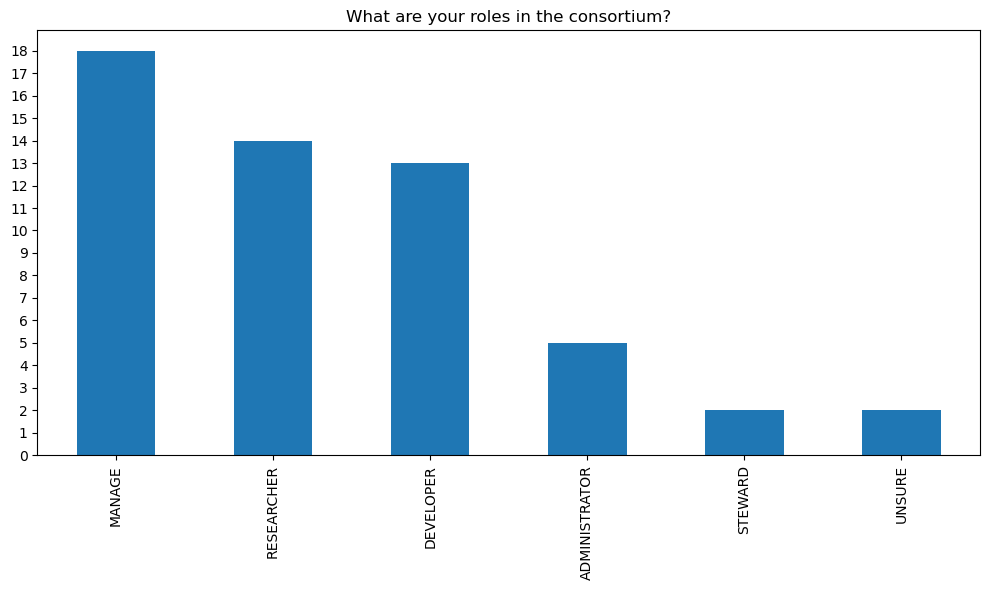

'Of the 34 participants, 18 identified themselves with the role of manager, 14 as researcher and 13 as developer.'

'Administrators (5) and stewards (2) were represented less and 2 were unsure.'

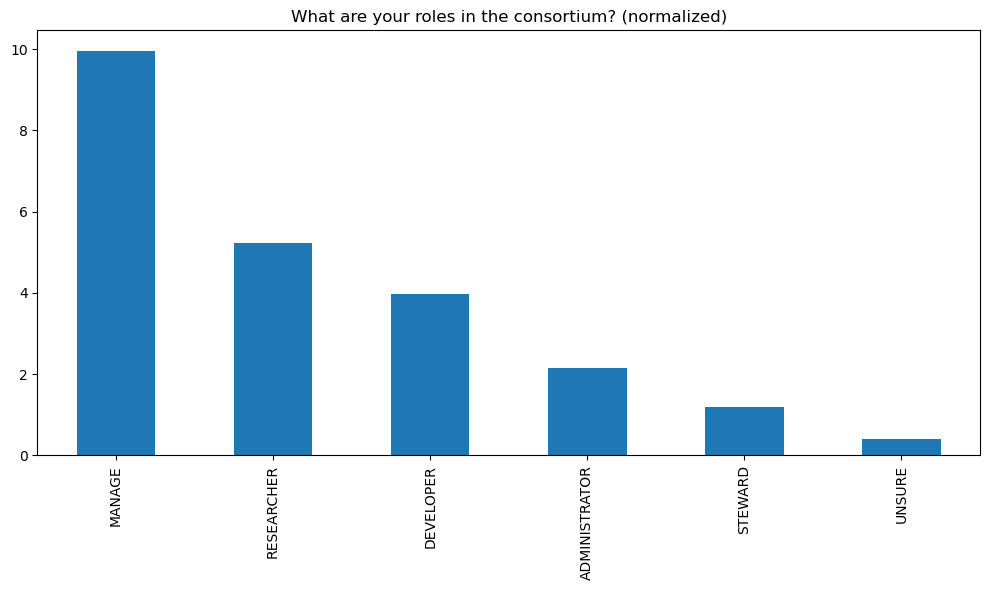

In [37]:
roles = col_count("role","What are your roles in the consortium?")
display(f"Of the {len(df)} participants, {roles["MANAGE"]} identified themselves with the role of manager, {roles["RESEARCHER"]} as researcher and {roles["DEVELOPER"]} as developer.")
display(f"Administrators ({roles["ADMINISTRATOR"]}) and stewards ({roles["STEWARD"]}) were represented less and {roles["UNSURE"]} were unsure.")
col_count_normalize("role","What are your roles in the consortium?")
display(f"Developer and researcher often occured together {roles["RESEARCHER"]} as researcher and {roles["DEVELOPER"]} as developer.")


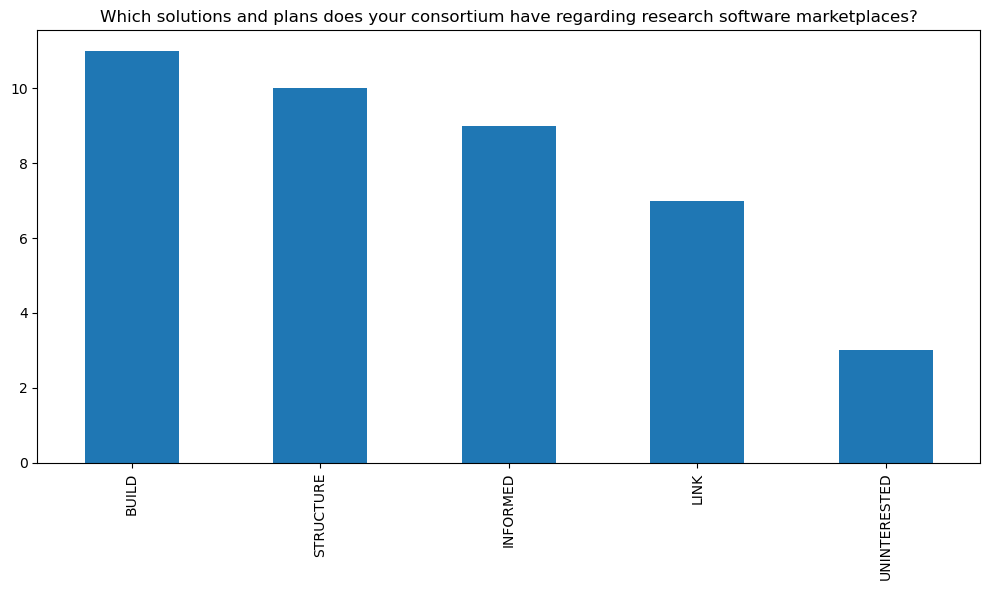

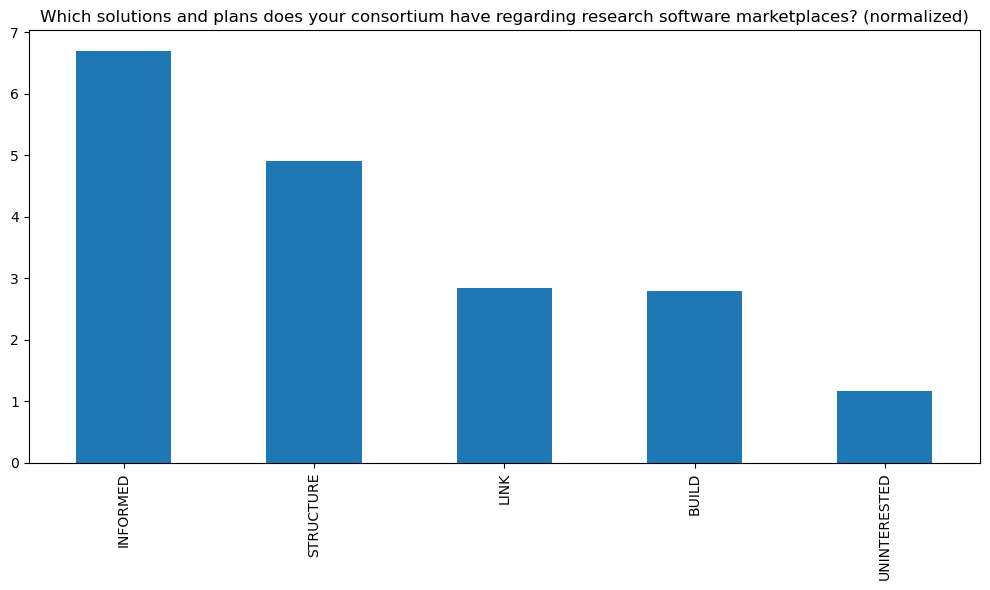

In [24]:
col_count("solutions","Which solutions and plans does your consortium have regarding research software marketplaces?")
col_count_normalize("solutions","Which solutions and plans does your consortium have regarding research software marketplaces?")

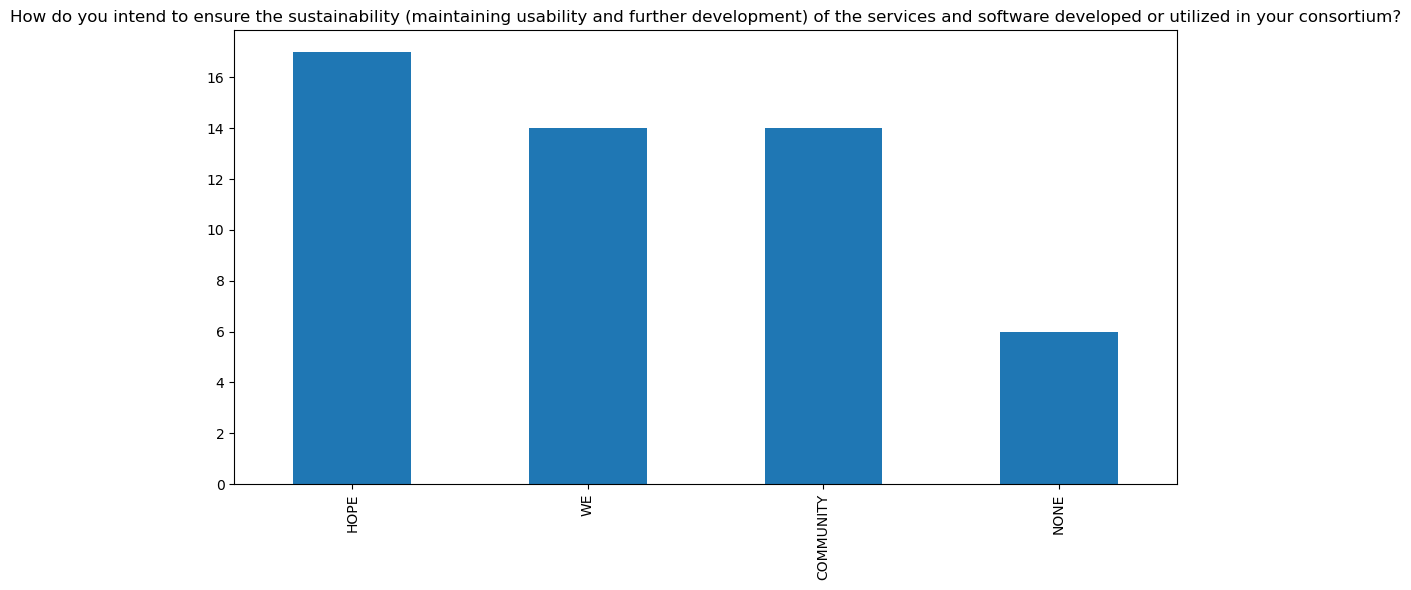

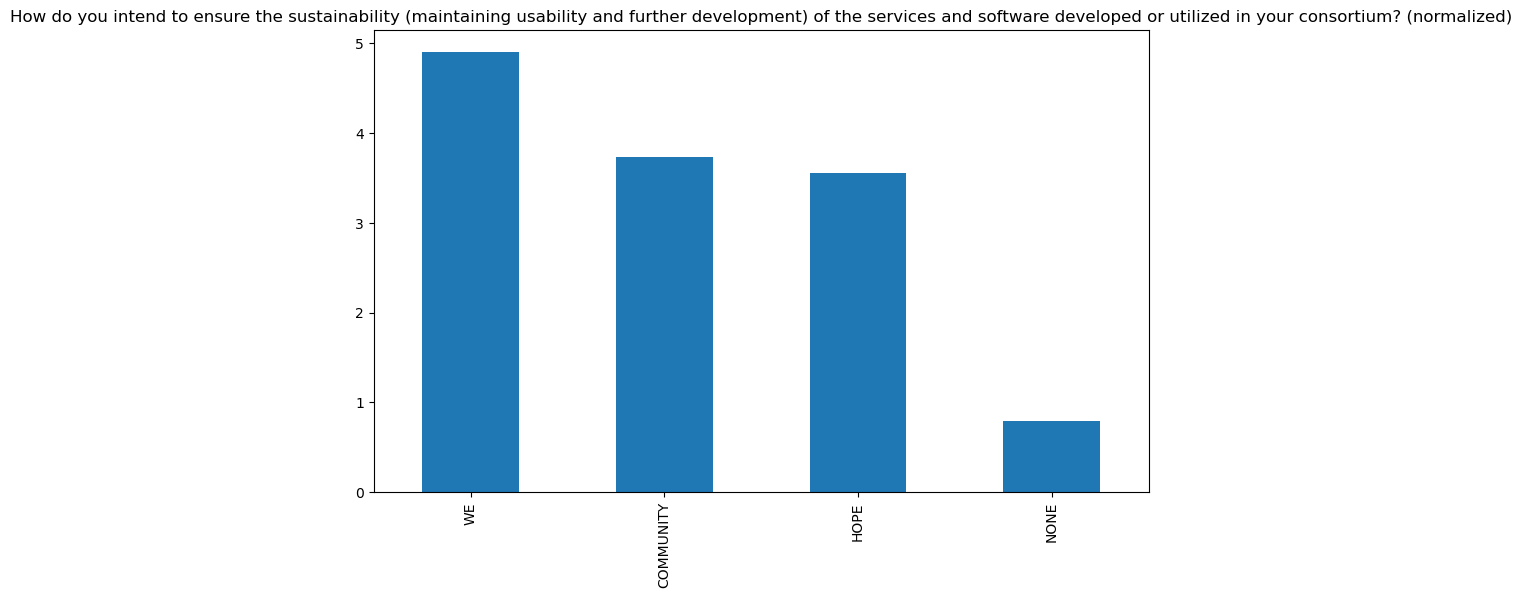

{'NONE': 0.7944444444444444,
 'COMMUNITY': 3.733333333333333,
 'WE': 4.902777777777778,
 'HOPE': 3.558333333333333}

In [50]:
col_count("sustain","How do you intend to ensure the sustainability (maintaining usability and further development) of the services and software developed or utilized in your consortium?")
col_count_normalize("sustain","How do you intend to ensure the sustainability (maintaining usability and further development) of the services and software developed or utilized in your consortium?")

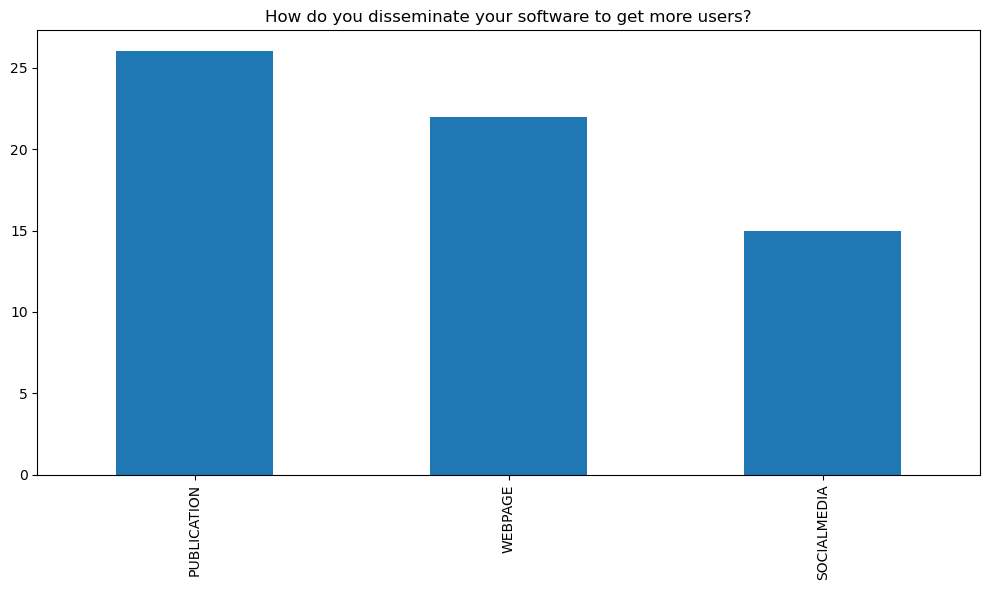

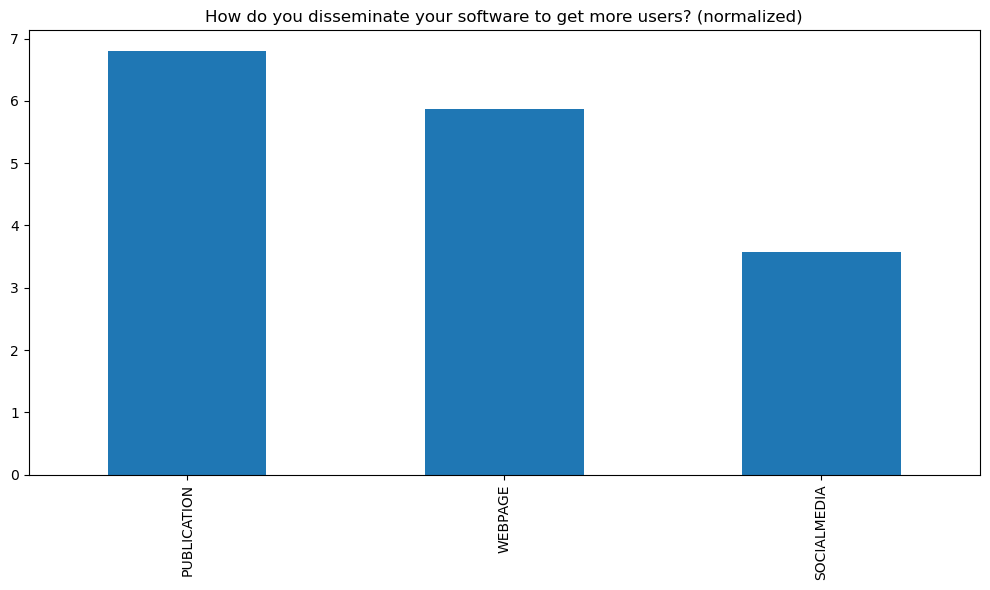

{'PUBLICATION': 6.791666666666667,
 'SOCIALMEDIA': 3.566666666666667,
 'WEBPAGE': 5.875}

In [52]:
col_count("disseminate","How do you disseminate your software to get more users?")
col_count_normalize("disseminate","How do you disseminate your software to get more users?")

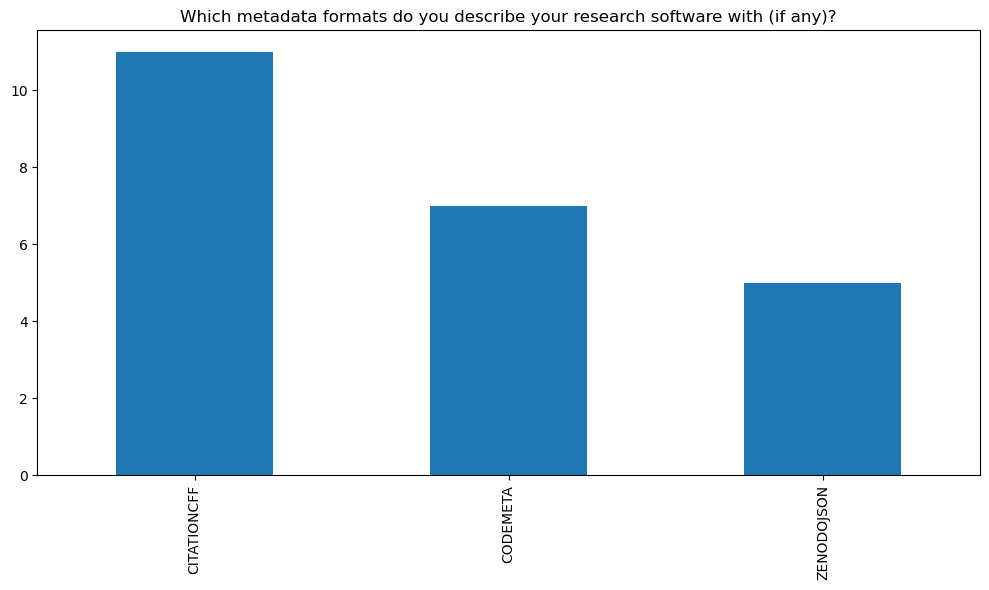

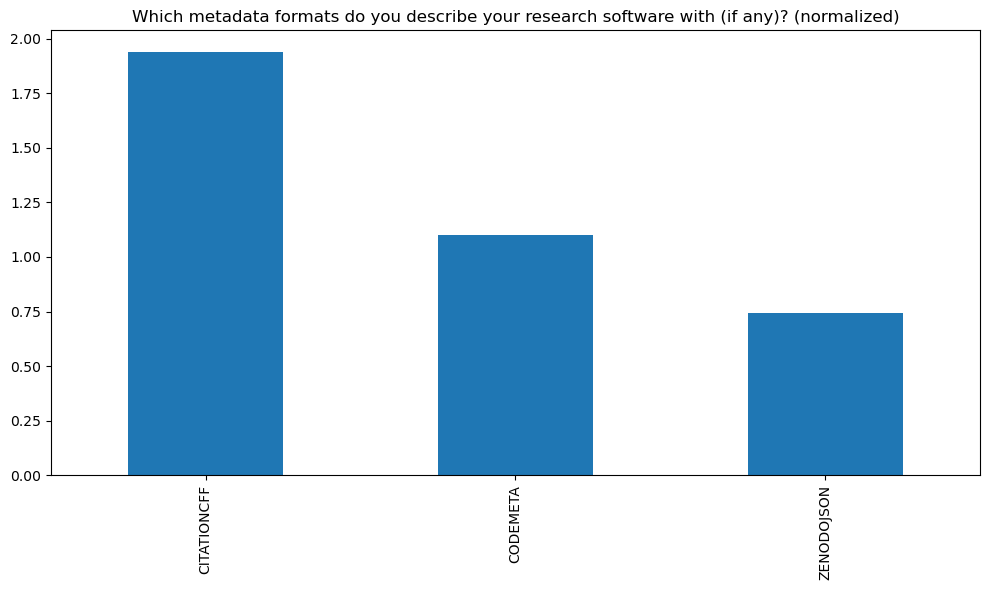

{'ZENODOJSON': 0.7444444444444444,
 'CITATIONCFF': 1.9416666666666669,
 'CODEMETA': 1.1}

In [53]:
col_count("metadata","Which metadata formats do you describe your research software with (if any)?")
col_count_normalize("metadata","Which metadata formats do you describe your research software with (if any)?")

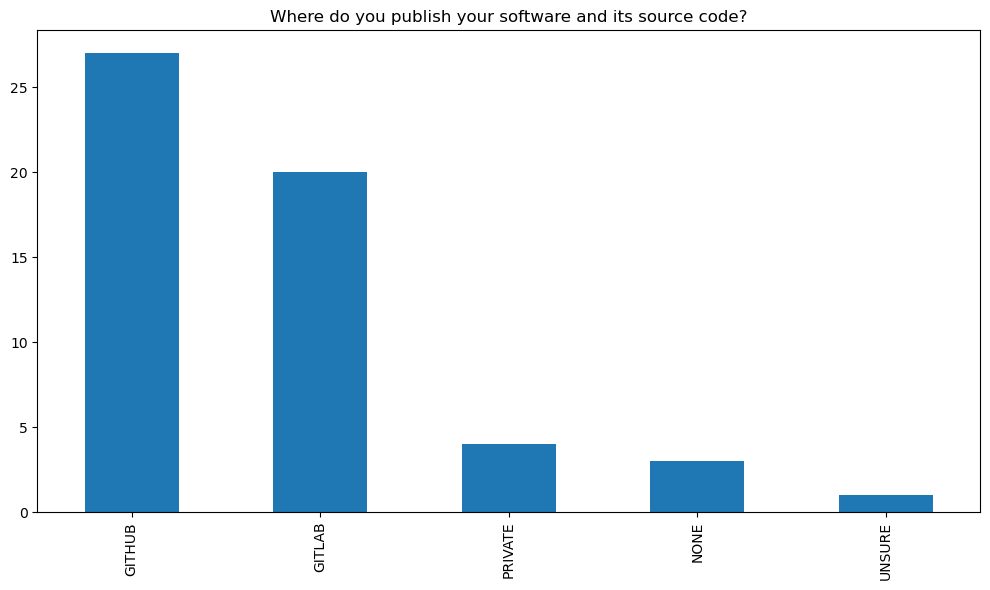

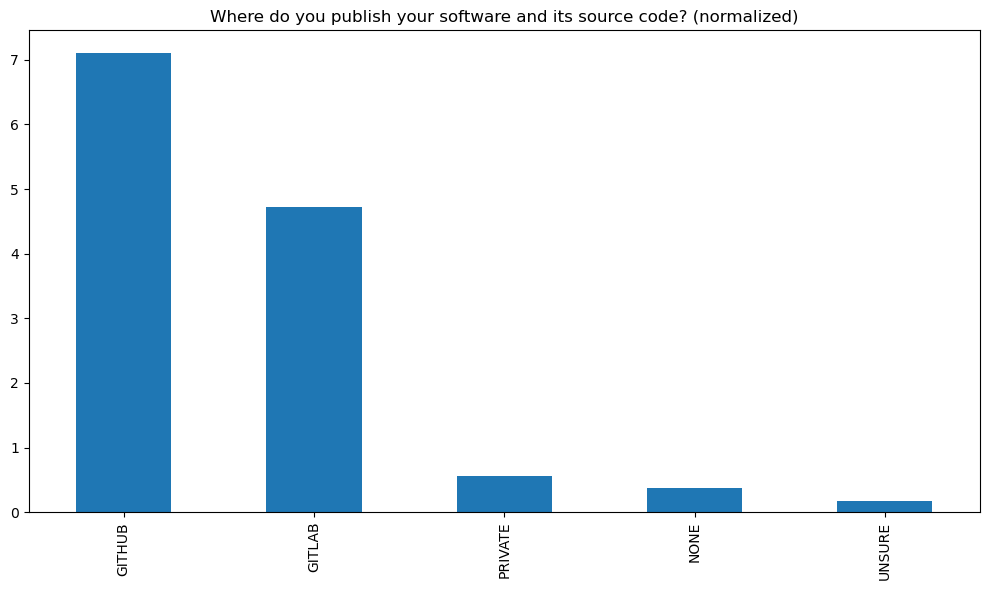

{'GITHUB': 7.1000000000000005,
 'PRIVATE': 0.5583333333333333,
 'GITLAB': 4.722222222222222,
 'NONE': 0.375,
 'UNSURE': 0.16666666666666666}

In [54]:
col_count("sourcecode","Where do you publish your software and its source code?")
col_count_normalize("sourcecode","Where do you publish your software and its source code?")

The problem with all those answers is that they are strongly biased by different participation ranging from 0 to 11 answers per consortium.
Thus we also look into the normalized values.
Ideally, there should be identical answers within each consortium but we suspect this won't be the case in practise, so we also look at the differences.
However the non-normalized values also shouldn't be discounted because if we assume participation is correlated with consortium size (or expressed in another way the probability of answering is not correlated by the consortium), then we can just treat the non-normalized values as samples from the whole of NFDI and the answers as based on the individual practises.
For example, if Persons A and B both belong to consortium C, and A answers GitHub and B answers GitLab to the source code question, then this doesn't need to mean that one got the answer wrong, just that there is no single answer that is valid for all people in that consortium.

Now that we have created all the aggregate columns, we can create a printable version for the document at the end.

In [44]:
def format_set(s):
    if isinstance(s, set):
        return ', '.join(sorted(s))
    else:
        return s

cols  = ['consortium', 'role']
for col in cols:
    df[col] = df[col].apply(format_set)

table_all = df.to_latex(columns=cols, index=False)
print(table_all)
with open('table_all.tex', 'w') as f:
    f.write(table_all)

\begin{tabular}{ll}
\toprule
consortium & role \\
\midrule
nfdi4cat & administrator, developer, manage \\
nfdi4biodiversity & administrator, developer, researcher \\
nfdi4microbiota & manage \\
nfdimatwerk & developer \\
berd & manage \\
dataplant & manage \\
nfdi4ing & developer, manage, researcher \\
nfdi4bioimage & steward \\
nfdi4ing & unsure \\
nfdi4chem, nfdi4culture, nfdi4memory, nfdi4objects & administrator, manage, researcher \\
nfdi4ing & manage \\
nfdi4cat & researcher \\
nfdi4biodiversity & developer \\
nfdi4chem & researcher \\
nfdi4immuno & developer \\
nfdi4biodiversity & researcher \\
nfdimatwerk & manage \\
nfdi4ing, nfdimatwerk & administrator, manage \\
nfdi4cat & researcher \\
nfdi4biodiversity & manage \\
konsortswd & developer, researcher \\
konsortswd & developer, researcher \\
nfdi4health & manage \\
ghga & manage \\
text & administrator, developer, manage, researcher \\
text & manage \\
nfdi4biodiversity & manage \\
nfdi4immuno & developer, manage, researcher \